# **TrackFlow Detect: AI-Powered Traffic Video Analyzer**

#### **Before running video.mp4, delete the previous video file — this is required if you're processing multiple videos one after anothe**

## Libraries

In [1]:
!pip install pytesseract
!pip install ultralytics
!pip install deep_sort_realtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

## **We take the video link if it's uploaded on Dropbox, split it into separate hourly segments — not necessarily because it has to be split, but because we were working on an hourly basis — and then reupload the segments to Google Drive**



In [2]:
import os
import subprocess
from google.colab import drive

# STEP 1: Mount Google Drive
print("📦 Mounting Google Drive...")
drive.mount('/content/drive')

# STEP 2: Download video from Dropbox direct link
print("⬇️ Downloading video from Dropbox...")
video_url = "https://www.dropbox.com/scl/fo/fkxnw4c1snxl982tehrbt/AEPMLGAlqxDXPy3ttbs5KBI/Camera_01_TEST_TEST_20250429055959_20250429061611_835635.mp4?rlkey=82oxki5p6aptsubb7jz4b9qes&dl=1" # -> put the link of drop box here
output_video_path = "/content/long_video.mp4"
subprocess.run(["wget", video_url, "-O", output_video_path], check=True)
print("✅ Download complete.")

# STEP 3: Get video duration with ffprobe
print("⏱ Checking video duration...")
ffprobe_cmd = [
    "ffprobe", "-v", "error",
    "-show_entries", "format=duration",
    "-of", "default=noprint_wrappers=1:nokey=1",
    output_video_path
]
result = subprocess.run(ffprobe_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
try:
    duration_sec = float(result.stdout.strip())
    print(f"📏 Video duration: {duration_sec:.2f} seconds")
except ValueError:
    print("❌ ffprobe failed to get duration.")
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
    raise

# STEP 4: Split the video
chunk_length = 3600  # 1 hour in seconds
chunks_dir = "/content/chunks_1"
os.makedirs(chunks_dir, exist_ok=True)

print("✂️ Splitting video into 1-hour chunks...")
num_chunks = int(duration_sec // chunk_length) + (1 if duration_sec % chunk_length > 0 else 0)

for i in range(num_chunks):
    start_time = i * chunk_length
    part_filename = f"part_{i+1:03}.mp4"
    part_path = os.path.join(chunks_dir, part_filename)
    print(f"⏳ Processing chunk {i+1}/{num_chunks}...")

    ffmpeg_cmd = [
        "ffmpeg",
        "-ss", str(start_time),
        "-i", output_video_path,
        "-t", str(chunk_length),
        "-c:v", "libx264",
        "-preset", "ultrafast",
        "-crf", "28",
        "-c:a", "aac",
        "-strict", "experimental",
        "-y", part_path
    ]
    subprocess.run(ffmpeg_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(f"✅ Saved: {part_path}")

import shutil

# STEP 5: Move all parts to Google Drive
output_drive_dir = "/content/drive/MyDrive/video_parts_1"
os.makedirs(output_drive_dir, exist_ok=True)
print("📂 Moving chunks to Google Drive...")
for file in os.listdir(chunks_dir):
    src = os.path.join(chunks_dir, file)
    dst = os.path.join(output_drive_dir, file)
    shutil.move(src, dst)
print("✅ All chunks moved to Google Drive folder: video_parts_1")


📦 Mounting Google Drive...


MessageError: Error: credential propagation was unsuccessful

## **Example : https://drive.google.com/file/d/1KRFInFIz93l1EpqryfL7RAEGuRmmh97x/view?usp=sharing**|-> id : 1KRFInFIz93l1EpqryfL7RAEGuRmmh97x

## *We define the coordinates here because we’ll need them later when setting the height and the endpoint of each line.*

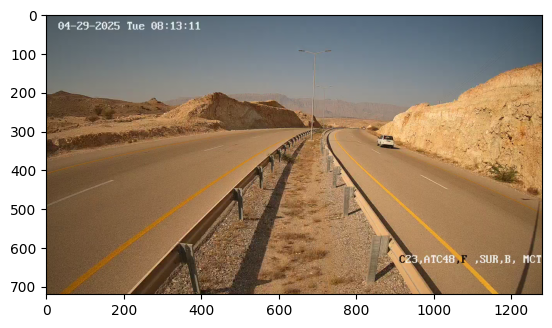

In [13]:
import cv2
import matplotlib.pyplot as plt
import gdown
import os

# Google Drive video ID and target filename
drive_video_id = "1KRFInFIz93l1EpqryfL7RAEGuRmmh97x"  # Change this to your video ID
video_filename = "video_1.mp4"

# Download the video if it's not already present
if not os.path.exists(video_filename):
    url = f"https://drive.google.com/uc?id={drive_video_id}"
    gdown.download(url, video_filename, quiet=False)

# Read the first frame from the video
cap = cv2.VideoCapture(video_filename)
ret, frame = cap.read()
cap.release()

if not ret:
    print("Failed to read video")
    exit()

coords = []

# Show frame
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()




## **Goooo ooon**

# *We determine these points*
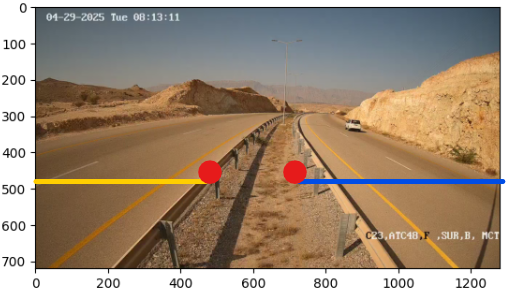



In [6]:
# car_counter_optimized.py

import os
import re
import cv2
import gdown
import numpy as np
from PIL import Image as PILImage
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple
import pytesseract
from ultralytics import YOLO
from openpyxl.utils import get_column_letter
from openpyxl import Workbook
import pandas as pd

model = YOLO("yolov8x.pt")

# --- CONFIG ---
DRIVE_VIDEO_ID: str = "1KRFInFIz93l1EpqryfL7RAEGuRmmh97x" # change with your id
VIDEO_FILENAME: str = "video.mp4"
OUTPUT_DIR: str = "car_screenshots_"
OUTPUT_VIDEO_NAME: str = "output.mp4"
TEMP_IMG_PATH: str = "temp_first_frame.jpg"

# Detection fine-tuned thresholds for high accuracy + performance (Colab-friendly)
LARGURA_MIN_CFG: int = 30   # Ignore tiny detections
ALTURA_MIN_CFG: int = 30
OFFSET_CFG: int = 12        # Wider margin to catch edge cases
TRACKING_LIFETIME_CFG: int = 8   # Slightly lower to avoid long-tracking noise

# Dynamic time gap logic (adaptive for fast vehicles)
TIME_GAP_THRESHOLD_CFG: float = 1.0
DET_DIST_THRESHOLD_CFG: int = 50  # Balanced value for tracking accuracy
VERY_FAST_SPEED_THRESHOLD_PIX_PER_SEC_CFG: float = 350.0
SHORT_TIME_GAP_THRESHOLD_CFG: float = 0.2
MIN_CONSECUTIVE_FAST_DETECTIONS_CFG: int = 2


def pega_centro(x: int, y: int, w: int, h: int) -> Tuple[int, int]:
    return x + w // 2, y + h // 2

def distance(p1: Tuple[int, int], p2: Tuple[int, int]) -> float:
    return np.linalg.norm(np.array(p1) - np.array(p2))

def crop_frame_side(frame: np.ndarray, side: str, portion: float = 0.5) -> np.ndarray:
    h, w, _ = frame.shape
    if side == "Left": return frame[:, :int(w * portion)]
    elif side == "Right": return frame[:, int(w * (1 - portion)):]
    return frame

def sanitize_sheet_title(title_str: str) -> str:
    return re.sub(r'[\\/?*\[\]:]', "", title_str)[:31]

def sanitize_filename(name_str: str) -> str:
    sanitized = re.sub(r'[<>:"/\\|?*]', '_', name_str)
    return re.sub(r'\s+', '_', sanitized).strip('_')[:200]

def get_filename_interval_end_time(interval_start_dt: datetime) -> datetime:
    calc_base = interval_start_dt.replace(second=0, microsecond=0)
    if interval_start_dt.second > 0 or interval_start_dt.microsecond > 0:
        calc_base += timedelta(minutes=1)
    current_minute_of_calc_base = calc_base.minute
    if current_minute_of_calc_base % 15 == 0: return calc_base + timedelta(minutes=15)
    else: return calc_base + timedelta(minutes=(15 - (current_minute_of_calc_base % 15)))

def setup_environment() -> None:
    if not os.path.exists(VIDEO_FILENAME):
        gdown.download(f"https://drive.google.com/uc?id={DRIVE_VIDEO_ID}", VIDEO_FILENAME, quiet=False)
    if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)


def initialize_settings(cap: cv2.VideoCapture, frame_h: int, frame_w: int) -> Tuple[Optional[datetime], Optional[str], int, int, int, float]:
    fps_val = cap.get(cv2.CAP_PROP_FPS)
    if fps_val == 0 or fps_val is None: fps_val = 25.0
    print("Attempting OCR for start time and site code...")
    ret, first_frame = cap.read()
    if not ret or first_frame is None: return None, None, 0, 0, 0, fps_val
    cv2.imwrite(TEMP_IMG_PATH, first_frame)
    ocr_text, video_start_time_obj, site_code_val = "", None, None
    try:
        ocr_text = pytesseract.image_to_string(PILImage.open(TEMP_IMG_PATH))
        print(f"OCR Text: ---\n{ocr_text}\n---")
    except Exception: print(f"OCR Text: ---\n\n\x0c\n---")
    finally:
        if os.path.exists(TEMP_IMG_PATH): os.remove(TEMP_IMG_PATH)

    if ocr_text:
        time_match = re.search(r"(\d{1,2}:\d{2}:\d{2})", ocr_text)
        if time_match:
            try: video_start_time_obj = datetime.strptime(time_match.group(1), "%H:%M:%S").time()
            except ValueError: video_start_time_obj = None
        if not video_start_time_obj: print("OCR: No time found.")

        site_code_match = re.search(r"(ATC\s*,\s*\d+)", ocr_text, re.IGNORECASE)
        if site_code_match:
            parts = site_code_match.group(1).split(',')
            site_code_val = f"{parts[0].strip().upper()},{parts[1].strip()}" if len(parts) == 2 else site_code_match.group(1).replace(" ", "").upper()
        else: print("OCR: No site code (ATC,XX) found.")
    else:
        print("OCR: No time found.")
        print("OCR: No site code (ATC,XX) found.")

    if video_start_time_obj is None:
        while True:
            try:
                video_start_time_obj = datetime.strptime(input("Manual Start Time (HH:MM:SS): "), "%H:%M:%S").time()
                print(f"Manual Time: {video_start_time_obj.strftime('%H:%M:%S')}"); break
            except ValueError: pass
    if site_code_val is None:
        while True:
            manual_site_code = input("Manual Site Code (e.g., ATC,52): ")
            if manual_site_code.strip():
                site_code_val = manual_site_code.strip().upper().replace(" ", ""); print(f"Manual Site: {site_code_val}"); break

    video_start_dt = datetime.combine(datetime.min.date(), video_start_time_obj)
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    default_ly = int(frame_h * 0.75); ly_str = input(f"Y-pos for lines (def {default_ly}): "); line_y = int(ly_str) if ly_str.isdigit() and 0 < int(ly_str) < frame_h else default_ly; print(f"Line Y: {line_y}")
    default_lx_end = int(frame_w * 0.45); lx_str = input(f"X-end LEFT line (def {default_lx_end}): "); left_x = int(lx_str) if lx_str.isdigit() and 0 < int(lx_str) < frame_w else default_lx_end; print(f"Left X-end: {left_x}")
    default_rx_start = int(frame_w * 0.55); rx_str = input(f"X-start RIGHT line (def {default_rx_start}): "); right_x = int(rx_str) if rx_str.isdigit() and left_x < int(rx_str) < frame_w else default_rx_start; print(f"Right X-start: {right_x}")
    if right_x <= left_x: right_x = min(frame_w - 1, left_x + int(frame_w * 0.1))
    return video_start_dt, site_code_val, line_y, left_x, right_x, fps_val


In [8]:
def process_video(cap: cv2.VideoCapture, vid_start_dt: datetime,
                  ln_y: int, lx_end: int, rx_start: int, fps: float,
                  out_vid: cv2.VideoWriter, bg_sub: cv2.BackgroundSubtractor,
                  site_cd: Optional[str], frm_w: int) -> Tuple[Dict[str, List[Tuple[datetime, np.ndarray]]], int]:

    veh_count, frm_num = 0, 0
    car_data: Dict[str, List[Tuple[datetime, np.ndarray]]] = {"Left": [], "Right": []}
    tracked_objs: Dict[int, Tuple[Tuple[int, int], int, bool, int, float, int]] = {}
    next_obj_id = 1
    last_cap_frm_L: Optional[int] = None
    last_cap_frm_R: Optional[int] = None

    lp1L, lp2L = (0, ln_y), (lx_end, ln_y)
    lp1R, lp2R = (rx_start, ln_y), (frm_w, ln_y)

    print("Processing video...")

    while True:
        ret, frame = cap.read()
        if not ret: break
        frm_num += 1
        if frm_num % 2 != 0: continue  # Process every 2nd frame for speed

        curr_time_s = frm_num / fps
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 3)
        fg_mask = bg_sub.apply(blur)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, np.ones((3, 3)))

        contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        current_centers = []

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w >= LARGURA_MIN_CFG and h >= ALTURA_MIN_CFG:
                center = pega_centro(x, y, w, h)
                current_centers.append(center)

        updated_objs = {}
        matched_ids = set()

        for center in current_centers:
            matched = False
            for obj_id, (prev_center, ttl, counted, last_seen, speed, fast_count) in tracked_objs.items():
                if distance(center, prev_center) < DET_DIST_THRESHOLD_CFG:
                    delta_frames = frm_num - last_seen
                    spd = distance(center, prev_center) / (delta_frames / fps) if delta_frames else 0.0
                    fast_count = fast_count + 1 if spd > VERY_FAST_SPEED_THRESHOLD_PIX_PER_SEC_CFG else 0
                    updated_objs[obj_id] = (center, TRACKING_LIFETIME_CFG, counted, frm_num, spd, fast_count)
                    matched_ids.add(obj_id)
                    matched = True
                    break
            if not matched:
                updated_objs[next_obj_id] = (center, TRACKING_LIFETIME_CFG, False, frm_num, 0.0, 0)
                next_obj_id += 1

        for obj_id, obj in tracked_objs.items():
            if obj_id not in matched_ids:
                ttl = obj[1] - 1
                if ttl > 0:
                    updated_objs[obj_id] = (obj[0], ttl, obj[2], obj[3], obj[4], obj[5])

        tracked_objs = updated_objs
        cv2.line(frame, lp1L, lp2L, (0, 255, 255), 2)
        cv2.line(frame, lp1R, lp2R, (0, 255, 255), 2)

        for obj_id, (center, ttl, counted, last_seen, spd, fast_count) in tracked_objs.items():
            if not counted and (ln_y - OFFSET_CFG) < center[1] < (ln_y + OFFSET_CFG):
                side = "Left" if center[0] < lx_end else "Right" if center[0] > rx_start else None
                if side:
                    last_cap_frm = last_cap_frm_L if side == "Left" else last_cap_frm_R
                    delta_s = curr_time_s - (last_cap_frm / fps if last_cap_frm else -999)
                    use_short_gap = fast_count >= MIN_CONSECUTIVE_FAST_DETECTIONS_CFG
                    time_gap = SHORT_TIME_GAP_THRESHOLD_CFG if use_short_gap else TIME_GAP_THRESHOLD_CFG

                    if delta_s > time_gap:
                        dt = vid_start_dt + timedelta(seconds=curr_time_s)
                        car_img = crop_frame_side(frame, side)
                        car_data[side].append((dt, car_img))
                        veh_count += 1
                        print(f"[{side}] Car #{veh_count} at {dt.strftime('%H:%M:%S')}")
                        if side == "Left": last_cap_frm_L = frm_num
                        else: last_cap_frm_R = frm_num
                        tracked_objs[obj_id] = (center, ttl, True, last_seen, spd, fast_count)

        cv2.putText(frame, f"COUNT: {veh_count}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        cv2.putText(frame, f"Site: {site_cd or 'N/A'}", (frm_w - 300, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 2)
        out_vid.write(frame)

    return car_data, frm_num


from openpyxl.utils import get_column_letter

from collections import Counter

def save_excel_reports(car_data: Dict[str, List[Tuple[datetime, np.ndarray]]],
                       total_frms: int, fps: float, vid_start_dt: datetime,
                       site_cd: Optional[str], out_dir: str) -> None:
    if total_frms == 0: return
    vid_dur_s = total_frms / fps
    vid_end_dt = vid_start_dt + timedelta(seconds=vid_dur_s)

    effective_site_cd = site_cd if site_cd else "DefaultSite"
    fn_site_code = sanitize_filename(effective_site_cd.replace(',', ' '))

    img_w, img_h, row_h = 160, 90, (90 * 0.75) + 10
    colA_w, colB_w, colC_w = 12, (160 / 7.0) + 2, 15

    curr_fn_start_dt, curr_data_low_bnd = vid_start_dt, vid_start_dt

    while curr_data_low_bnd < vid_end_dt:
        fn_part_end_dt = get_filename_interval_end_time(curr_fn_start_dt)
        curr_data_up_bnd = min(fn_part_end_dt, vid_end_dt)

        fn_start_str = curr_fn_start_dt.strftime("%H-%M-%S")
        fn_end_str = curr_data_up_bnd.strftime("%H-%M-%S")

        for side in ["Left", "Right"]:
            segment_cars = []
            is_last_segment = (curr_data_up_bnd == vid_end_dt)

            for ts, img_d in car_data[side]:
                if ts >= curr_data_low_bnd and (
                    (is_last_segment and ts <= curr_data_up_bnd) or
                    (not is_last_segment and ts < curr_data_up_bnd)):
                    segment_cars.append((ts, img_d))

            if not segment_cars:
                continue

            xl_fn = f"{fn_site_code}_{side}_{fn_start_str}_to_{fn_end_str}.xlsx"
            xl_path = os.path.join(out_dir, xl_fn)

            wb = Workbook()
            wb.remove(wb.active)
            ws = wb.create_sheet(title=sanitize_sheet_title(f"{side} Detections"))
            ws.append(["Timestamp", "Detected Car Image", "Vehicle Type"])
            ws.column_dimensions['A'].width = colA_w
            ws.column_dimensions['B'].width = colB_w
            ws.column_dimensions['C'].width = colC_w

            type_counts = Counter()

            for i, (ts, img_d_cv) in enumerate(segment_cars, 1):
                r_num = i + 1
                img_rep_fn = f"{fn_site_code}_{side}_{ts.strftime('%H%M%S%f')}_{i}.jpg"
                img_pth_rep = os.path.join(out_dir, img_rep_fn)

                try:
                    cv2.imwrite(img_pth_rep, img_d_cv)
                except Exception as e_imwrite:
                    print(f"Error saving image {img_rep_fn}: {e_imwrite}")
                    ws.cell(row=r_num, column=2, value="Img Save Err")
                    continue

                ws.cell(row=r_num, column=1, value=ts.strftime("%H:%M:%S"))

                try:
                    xl_img = XLImage(img_pth_rep)
                    xl_img.width = img_w
                    xl_img.height = img_h
                    ws.add_image(xl_img, f"B{r_num}")
                    ws.row_dimensions[r_num].height = row_h
                except Exception as e_xl_img:
                    print(f"Error adding image {img_rep_fn} to Excel: {e_xl_img}")
                    ws.cell(row=r_num, column=2, value="Img Load Err")

                try:
                    results = model(img_pth_rep)
                    if results and results[0].boxes.cls.numel() > 0:
                        cls_index = int(results[0].boxes.cls[0])
                        label = results[0].names[cls_index]
                    else:
                        label = "Unknown"
                    ws.cell(row=r_num, column=3, value=label)
                    type_counts[label] += 1
                except Exception as e_class:
                    print(f"Error running YOLO on {img_rep_fn}: {e_class}")
                    ws.cell(row=r_num, column=3, value="YOLO Error")

            summary_ws = wb.create_sheet("Summary")
            summary_ws.append(["Vehicle Type", "Count"])
            for vehicle_type, count in type_counts.items():
                summary_ws.append([vehicle_type, count])

            try:
                wb.save(xl_path)
            except Exception as e_wb_save:
                print(f"ERROR saving Excel file '{xl_path}': {e_wb_save}")

        curr_fn_start_dt = fn_part_end_dt
        curr_data_low_bnd = curr_data_up_bnd
        if curr_data_low_bnd >= vid_end_dt:
            break


def main():
    setup_environment()
    cap = cv2.VideoCapture(VIDEO_FILENAME)
    if not cap.isOpened():
        print(f"Error: Could not open video file {VIDEO_FILENAME}")
        return

    frame_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    vid_start_dt, site_cd, ln_y, lx_end, rx_start, fps = initialize_settings(cap, frame_h, frame_w)
    if vid_start_dt is None:
        print("Failed to initialize settings. Exiting.")
        cap.release()
        return

    out_vid = cv2.VideoWriter(OUTPUT_VIDEO_NAME, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_w, frame_h))
    bg_sub = cv2.createBackgroundSubtractorKNN(history=200, dist2Threshold=400.0, detectShadows=True)

    detected_data, total_frms = process_video(cap, vid_start_dt, ln_y, lx_end, rx_start, fps, out_vid, bg_sub, site_cd, frame_w)

    cap.release()
    out_vid.release()

    save_excel_reports(detected_data, total_frms, fps, vid_start_dt, site_cd, OUTPUT_DIR)

    print("Processing complete.")

if __name__ == "__main__":
    main()




Attempting OCR for start time and site code...
OCR Text: ---
 

---
OCR: No time found.
OCR: No site code (ATC,XX) found.
Manual Start Time (HH:MM:SS): 08:13:11
Manual Time: 08:13:11
Manual Site Code (e.g., ATC,52): ATC 48
Manual Site: ATC48
Y-pos for lines (def 540): 350
Line Y: 350
X-end LEFT line (def 576): 600
Left X-end: 600
X-start RIGHT line (def 704): 
Right X-start: 704
Processing video...
[Right] Car #1 at 08:13:15
[Right] Car #2 at 08:13:53
[Left] Car #3 at 08:14:13
[Left] Car #4 at 08:14:13
[Right] Car #5 at 08:14:15
[Left] Car #6 at 08:14:20
[Right] Car #7 at 08:14:49
[Right] Car #8 at 08:14:50
[Left] Car #9 at 08:15:03
[Right] Car #10 at 08:15:09
[Left] Car #11 at 08:15:30
[Left] Car #12 at 08:15:31
[Left] Car #13 at 08:15:40
[Left] Car #14 at 08:15:40
[Right] Car #15 at 08:16:01
[Right] Car #16 at 08:16:03
[Left] Car #17 at 08:16:24
[Right] Car #18 at 08:16:39
[Left] Car #19 at 08:17:10
[Left] Car #20 at 08:17:15
[Right] Car #21 at 08:17:31
[Left] Car #22 at 08:17:45
[L

# **The output Excel file will be located in the car_screenshots folder, at the beginning of each side — whether left or right.**